In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import datetime 
from tqdm import tqdm
# import cudf
# import cupy as cp
# import cuml

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from metric import score 


column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

# Data Engineering

In [2]:
dt_transforms = [
    pl.col('timestamp').str.to_datetime(), 
    (pl.col('timestamp').str.to_datetime().dt.year()-2000).cast(pl.UInt8).alias('year'), 
    pl.col('timestamp').str.to_datetime().dt.month().cast(pl.UInt8).alias('month'),
    pl.col('timestamp').str.to_datetime().dt.day().cast(pl.UInt8).alias('day'), 
    pl.col('timestamp').str.to_datetime().dt.hour().cast(pl.UInt8).alias('hour')
]

data_transforms = [
    pl.col('anglez').cast(pl.Int16), # Casting anglez to 16 bit integer
    (pl.col('enmo')*1000).cast(pl.UInt16), # Convert enmo to 16 bit uint
]

train_series = pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

train_events = pl.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv').with_columns(
    dt_transforms
    )

test_series = pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

# Getting series ids as a list for convenience
series_ids = train_events['series_id'].unique(maintain_order=True).to_list()

# Removing series with mismatched counts: 
onset_counts = train_events.filter(pl.col('event')=='onset').group_by('series_id').count().sort('series_id')['count']
wakeup_counts = train_events.filter(pl.col('event')=='wakeup').group_by('series_id').count().sort('series_id')['count']

counts = pl.DataFrame({'series_id':sorted(series_ids), 'onset_counts':onset_counts, 'wakeup_counts':wakeup_counts})
count_mismatches = counts.filter(counts['onset_counts'] != counts['wakeup_counts'])

train_series = train_series.filter(~pl.col('series_id').is_in(count_mismatches['series_id']))
train_events = train_events.filter(~pl.col('series_id').is_in(count_mismatches['series_id']))

# Updating list of series ids, not including series with no non-null values.
series_ids = train_events.drop_nulls()['series_id'].unique(maintain_order=True).to_list()

In [3]:
features, feature_cols = [pl.col('hour')], ['hour']

for mins in [5, 30, 60*2, 60*8] :
    features += [
        pl.col('enmo').rolling_mean(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_mean'),
        pl.col('enmo').rolling_max(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_max')
    ]

    feature_cols += [ 
        f'enmo_{mins}m_mean', f'enmo_{mins}m_max'
    ]

    # Getting first variations
    for var in ['enmo', 'anglez'] :
        features += [
            (pl.col(var).diff().abs().rolling_mean(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
            (pl.col(var).diff().abs().rolling_max(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max')
        ]

        feature_cols += [ 
            f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max'
        ]

id_cols = ['series_id', 'step', 'timestamp']

train_series = train_series.with_columns(
    features
).select(id_cols + feature_cols)

test_series = test_series.with_columns(
    features
).select(id_cols + feature_cols)

In [4]:
def make_train_dataset(train_data, train_events, drop_nulls=False) :
    
    series_ids = train_data['series_id'].unique(maintain_order=True).to_list()
    X, y = pl.DataFrame(), pl.DataFrame()
    for idx in tqdm(series_ids) : 
        
        # Normalizing sample features
        sample = train_data.filter(pl.col('series_id')==idx).with_columns(
            [(pl.col(col) / pl.col(col).std()).cast(pl.Float32) for col in feature_cols if col != 'hour']
        )
        
        events = train_events.filter(pl.col('series_id')==idx)
        
        if drop_nulls : 
            # Removing datapoints on dates where no data was recorded
            sample = sample.filter(
                pl.col('timestamp').dt.date().is_in(events['timestamp'].dt.date())
            )
        
        X = X.vstack(sample[id_cols + feature_cols])

        onsets = events.filter((pl.col('event') == 'onset') & (pl.col('step') != None))['step'].to_list()
        wakeups = events.filter((pl.col('event') == 'wakeup') & (pl.col('step') != None))['step'].to_list()

        # NOTE: This will break if there are event series without any recorded onsets or wakeups
        y = y.vstack(sample.with_columns(
            sum([(onset <= pl.col('step')) & (pl.col('step') <= wakeup) for onset, wakeup in zip(onsets, wakeups)]).cast(pl.Boolean).alias('asleep')
            ).select('asleep')
            )
    
    y = y.to_numpy().ravel()
    
    return X, y

In [6]:
%%time
from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(series_ids, train_size=0.7, random_state=42)

# We will collect datapoints at 10 minute intervals for training for validating
train_data = train_series.filter(pl.col('series_id').is_in(train_ids)).take_every(12 * 10).collect()

val_data = train_series.filter(pl.col('series_id').is_in(val_ids)).collect()
val_solution = train_events.filter(pl.col('series_id').is_in(val_ids)).select(['series_id', 'event', 'step']).to_pandas()
# train_data = train_data.drop("timestamp")
# Creating train dataset
train_events.to_pandas().to_parquet("train_events.parquet", index=False)
train_data.to_pandas().to_parquet("train_series.parquet", index=False)
val_data.to_pandas().to_parquet("val_data.parquet", index=False)
val_solution.to_parquet("val_solution.parquet", index=False)
X_train, y_train = make_train_dataset(train_data, train_events)

100%|██████████| 188/188 [00:03<00:00, 52.95it/s]

CPU times: user 11min 7s, sys: 3min 25s, total: 14min 33s
Wall time: 7min 29s


In [20]:
train_events = pl.read_parquet("/kaggle/input/sleepdetection/train_events.parquet")
train_data = pl.read_parquet("/kaggle/input/sleepdetection/train_series.parquet")
val_data = pl.read_parquet("/kaggle/input/sleepdetection/val_data.parquet")
val_solution = pl.read_parquet("/kaggle/input/sleepdetection/val_solution.parquet")

X_train, y_train = make_train_dataset(train_data, train_events)
train_events.shape, train_data.shape, val_data.shape, val_solution.shape

100%|██████████| 188/188 [00:03<00:00, 58.77it/s]


((14508, 9), (724329, 28), (37902600, 28), (4288, 3))

### Preprocessing before training

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = X_train[feature_cols]
# val_data = val_data[feature_cols]
# val_solution['event'] = LabelEncoder().fit_transform(val_solution['event'])
y = LabelEncoder().fit_transform(y_train)
# val_solution.drop(['series_id', "step"], axis=1, inplace=True)
# val_solution.reset_index(drop=True, inplace=True)
# val_solution = val_solution.to_numpy().flatten()

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((579463, 25), (144866, 25), (579463,), (144866,))

<h3 style="color:blue;">Training and validating random forest</h3>

In [ ]:
arrow_table = X_train[feature_cols].to_arrow()

# Convert Arrow table to cuDF DataFrame
X_train = cudf.DataFrame.from_arrow(arrow_table)

In [ ]:
import cuml
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier
from cuml.preprocessing import StandardScaler

cuRF = RandomForestClassifier(output_type="df_obj")
# X_train = X_train[feature_cols].to_numpy()
cuRF.fit(X_train, y_train)
print("Training Accuracy: ", cuRF.score(X_train, y_train ))

In [ ]:
from sklearn.metrics import classification_report

preds = gbc.predict(X_val)
print(classification_report(y_val, preds))

In [24]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

DT = DecisionTreeClassifier()

gbc = GradientBoostingClassifier(n_estimators=30, min_samples_leaf=10, random_state=42, verbose=True)
abc = AdaBoostClassifier(n_estimators=10)

ensemble_clf = StackingClassifier(
    estimators=[ ("ABC", AdaBoostClassifier()), ("Boosting", gbc), ("GBC", GaussianNB())],
    final_estimator= DecisionTreeClassifier(max_depth=5, random_state=42),  # You can choose another classifier as the final estimator
    verbose=True
)

clf = make_pipeline(StandardScaler(), ensemble_clf)
clf.fit(X_train[feature_cols], y_train)

print("Training Accuracy: ", clf.score(X_train, y_train))
print("Valid Accuracy: ", clf.score(X_val , y_val))

      Iter       Train Loss   Remaining Time 
         1           0.9733            2.89m
         2           0.8676            2.77m
         3           0.7831            2.66m
         4           0.7152            2.55m
         5           0.6578            2.46m
         6           0.6086            2.36m
         7           0.5656            2.25m
         8           0.5282            2.15m
         9           0.4969            2.05m
        10           0.4690            1.96m
        20           0.3218           58.62s
        30           0.2695            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.9738            2.25m
         2           0.8678            2.20m
         3           0.7834            2.12m
         4           0.7156            2.05m
         5           0.6581            1.99m
         6           0.6097            1.92m
         7           0.5666            1.83m
         8           0.5290            1.75m
        

### Neural Network 

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train[feature_cols].to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val[feature_cols].to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader for batching
batch_size = int(len(X_train)/2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_losses = []
val_losses = []
val_accuracies = []

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 2) 

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

mlp_model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

num_epochs = 500

# Add Cosine Annealing LR scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

print(f"Training model on {device}")

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    mlp_model.train()
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = mlp_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    # Update learning rate using scheduler
    scheduler.step()

    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Training Loss: {avg_loss:.4f}')
        mlp_model.eval()
        with torch.no_grad():
            outputs = mlp_model(X_val_tensor)
            val_loss = criterion(outputs, y_val_tensor)
            predictions = torch.argmax(outputs, dim=1)
            val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), predictions.cpu().numpy())
        train_losses.append(avg_loss)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)
        print(f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')

Training model on cpu


Epochs:   2%|▏         | 10/500 [02:03<1:40:46, 12.34s/it]

Training Loss: 0.5986
Validation Loss: 0.3141, Validation Accuracy: 0.8720


Epochs:   4%|▍         | 20/500 [04:07<1:38:38, 12.33s/it]

Training Loss: 0.2884
Validation Loss: 0.2821, Validation Accuracy: 0.8454


Epochs:   6%|▌         | 30/500 [06:10<1:34:55, 12.12s/it]

Training Loss: 0.2855
Validation Loss: 0.2309, Validation Accuracy: 0.9262


Epochs:   8%|▊         | 40/500 [08:16<1:37:09, 12.67s/it]

Training Loss: 0.2347
Validation Loss: 0.2138, Validation Accuracy: 0.9205


Epochs:  10%|█         | 50/500 [10:19<1:33:16, 12.44s/it]

Training Loss: 0.1473
Validation Loss: 0.2253, Validation Accuracy: 0.9220


Epochs:  12%|█▏        | 60/500 [12:23<1:32:42, 12.64s/it]

Training Loss: 0.2240
Validation Loss: 0.2001, Validation Accuracy: 0.9270


Epochs:  14%|█▍        | 70/500 [14:30<1:31:23, 12.75s/it]

Training Loss: 0.1349
Validation Loss: 0.1973, Validation Accuracy: 0.9319


Epochs:  16%|█▌        | 80/500 [16:36<1:27:59, 12.57s/it]

Training Loss: 0.1269
Validation Loss: 0.1899, Validation Accuracy: 0.9342


Epochs:  18%|█▊        | 90/500 [18:39<1:23:50, 12.27s/it]

Training Loss: 0.4853
Validation Loss: 0.1988, Validation Accuracy: 0.9240


Epochs:  20%|██        | 100/500 [20:44<1:23:12, 12.48s/it]

Training Loss: 0.1235
Validation Loss: 0.1852, Validation Accuracy: 0.9357


Epochs:  22%|██▏       | 110/500 [22:49<1:21:52, 12.60s/it]

Training Loss: 0.3832
Validation Loss: 0.1859, Validation Accuracy: 0.9312


Epochs:  24%|██▍       | 120/500 [24:53<1:18:37, 12.41s/it]

Training Loss: 0.2063
Validation Loss: 0.2077, Validation Accuracy: 0.9158


Epochs:  26%|██▌       | 130/500 [26:57<1:16:58, 12.48s/it]

Training Loss: 1.4171
Validation Loss: 0.2032, Validation Accuracy: 0.9288


Epochs:  28%|██▊       | 140/500 [29:00<1:14:11, 12.37s/it]

Training Loss: 0.3155
Validation Loss: 0.1881, Validation Accuracy: 0.9352


Epochs:  30%|███       | 150/500 [31:05<1:13:09, 12.54s/it]

Training Loss: 0.1201
Validation Loss: 0.1797, Validation Accuracy: 0.9404


Epochs:  32%|███▏      | 160/500 [33:08<1:09:55, 12.34s/it]

Training Loss: 0.1572
Validation Loss: 0.1877, Validation Accuracy: 0.9358


Epochs:  34%|███▍      | 170/500 [35:13<1:08:25, 12.44s/it]

Training Loss: 0.1186
Validation Loss: 0.1770, Validation Accuracy: 0.9406


Epochs:  36%|███▌      | 180/500 [37:17<1:05:46, 12.33s/it]

Training Loss: 0.1179
Validation Loss: 0.1752, Validation Accuracy: 0.9415


Epochs:  38%|███▊      | 190/500 [39:20<1:03:15, 12.24s/it]

Training Loss: 0.1232
Validation Loss: 0.1728, Validation Accuracy: 0.9422


Epochs:  40%|████      | 200/500 [41:25<1:02:27, 12.49s/it]

Training Loss: 0.2148
Validation Loss: 0.1775, Validation Accuracy: 0.9392


Epochs:  42%|████▏     | 210/500 [43:33<1:01:09, 12.65s/it]

Training Loss: 0.1444
Validation Loss: 0.1722, Validation Accuracy: 0.9406


Epochs:  44%|████▍     | 220/500 [45:38<57:44, 12.37s/it]  

Training Loss: 0.1149
Validation Loss: 0.1724, Validation Accuracy: 0.9404


Epochs:  46%|████▌     | 230/500 [47:46<57:43, 12.83s/it]

Training Loss: 0.1945
Validation Loss: 0.1670, Validation Accuracy: 0.9423


Epochs:  48%|████▊     | 240/500 [49:50<54:39, 12.61s/it]

Training Loss: 0.1423
Validation Loss: 0.1666, Validation Accuracy: 0.9421


Epochs:  50%|█████     | 250/500 [51:56<52:29, 12.60s/it]

Training Loss: 0.1102
Validation Loss: 0.1654, Validation Accuracy: 0.9430


Epochs:  52%|█████▏    | 260/500 [54:00<49:43, 12.43s/it]

Training Loss: 0.1152
Validation Loss: 0.1715, Validation Accuracy: 0.9401


Epochs:  54%|█████▍    | 270/500 [56:04<47:32, 12.40s/it]

Training Loss: 0.1115
Validation Loss: 0.1647, Validation Accuracy: 0.9427


Epochs:  56%|█████▌    | 280/500 [58:09<45:58, 12.54s/it]

Training Loss: 0.1117
Validation Loss: 0.1658, Validation Accuracy: 0.9424


Epochs:  58%|█████▊    | 290/500 [1:00:14<43:58, 12.57s/it]

Training Loss: 0.1091
Validation Loss: 0.1636, Validation Accuracy: 0.9433


Epochs:  60%|██████    | 300/500 [1:02:18<41:05, 12.33s/it]

Training Loss: 0.1912
Validation Loss: 0.1674, Validation Accuracy: 0.9415


Epochs:  62%|██████▏   | 310/500 [1:04:22<39:44, 12.55s/it]

Training Loss: 0.1157
Validation Loss: 0.1663, Validation Accuracy: 0.9421


Epochs:  64%|██████▍   | 320/500 [1:06:26<37:27, 12.49s/it]

Training Loss: 0.1196
Validation Loss: 0.1620, Validation Accuracy: 0.9438


Epochs:  66%|██████▌   | 330/500 [1:08:29<35:15, 12.44s/it]

Training Loss: 0.1078
Validation Loss: 0.1620, Validation Accuracy: 0.9438


Epochs:  68%|██████▊   | 340/500 [1:10:34<33:23, 12.52s/it]

Training Loss: 0.1248
Validation Loss: 0.1625, Validation Accuracy: 0.9437


Epochs:  70%|███████   | 350/500 [1:12:38<31:12, 12.48s/it]

Training Loss: 0.1092
Validation Loss: 0.1611, Validation Accuracy: 0.9440


Epochs:  72%|███████▏  | 360/500 [1:14:42<28:47, 12.34s/it]

Training Loss: 0.1770
Validation Loss: 0.1610, Validation Accuracy: 0.9440


Epochs:  74%|███████▍  | 370/500 [1:16:46<26:52, 12.40s/it]

Training Loss: 0.1072
Validation Loss: 0.1609, Validation Accuracy: 0.9441


Epochs:  76%|███████▌  | 380/500 [1:18:50<24:31, 12.26s/it]

Training Loss: 0.1082
Validation Loss: 0.1626, Validation Accuracy: 0.9433


Epochs:  78%|███████▊  | 390/500 [1:20:53<22:38, 12.35s/it]

Training Loss: 0.1383
Validation Loss: 0.1626, Validation Accuracy: 0.9434


Epochs:  80%|████████  | 400/500 [1:22:57<20:36, 12.36s/it]

Training Loss: 0.1082
Validation Loss: 0.1624, Validation Accuracy: 0.9436


Epochs:  82%|████████▏ | 410/500 [1:25:00<18:18, 12.21s/it]

Training Loss: 0.1606
Validation Loss: 0.1610, Validation Accuracy: 0.9441


Epochs:  84%|████████▍ | 420/500 [1:27:05<16:56, 12.71s/it]

Training Loss: 0.3034
Validation Loss: 0.1603, Validation Accuracy: 0.9446


Epochs:  86%|████████▌ | 430/500 [1:29:09<14:35, 12.50s/it]

Training Loss: 0.1067
Validation Loss: 0.1602, Validation Accuracy: 0.9446


Epochs:  88%|████████▊ | 440/500 [1:31:13<12:29, 12.50s/it]

Training Loss: 0.1069
Validation Loss: 0.1601, Validation Accuracy: 0.9447


Epochs:  90%|█████████ | 450/500 [1:33:17<10:18, 12.37s/it]

Training Loss: 0.1067
Validation Loss: 0.1602, Validation Accuracy: 0.9447


Epochs:  92%|█████████▏| 460/500 [1:35:21<08:12, 12.32s/it]

Training Loss: 0.1067
Validation Loss: 0.1601, Validation Accuracy: 0.9446


Epochs:  94%|█████████▍| 470/500 [1:37:25<06:10, 12.35s/it]

Training Loss: 0.6982
Validation Loss: 0.1601, Validation Accuracy: 0.9447


Epochs:  96%|█████████▌| 480/500 [1:39:30<04:09, 12.47s/it]

Training Loss: 0.1255
Validation Loss: 0.1601, Validation Accuracy: 0.9446


Epochs:  98%|█████████▊| 490/500 [1:41:37<02:07, 12.78s/it]

Training Loss: 0.1066
Validation Loss: 0.1601, Validation Accuracy: 0.9446


Epochs: 100%|██████████| 500/500 [1:43:46<00:00, 12.45s/it]

Training Loss: 0.1393
Validation Loss: 0.1601, Validation Accuracy: 0.9446


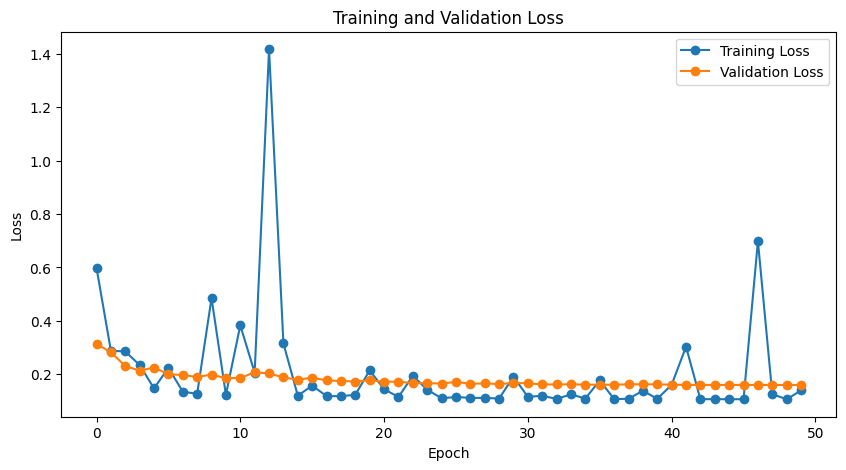

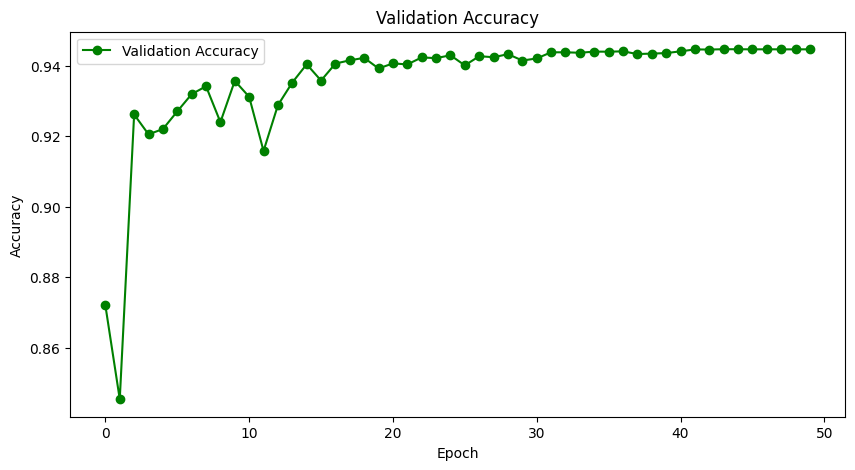

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


torch.save(mlp_model, "/kaggle/working/ChildSleepPredictor.pth")

In [38]:
from sklearn.metrics import classification_report
preds = torch.argmax(mlp_model(torch.tensor(X_val.to_numpy())), axis=1)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96    109305
           1       0.87      0.92      0.89     35561

    accuracy                           0.94    144866
   macro avg       0.92      0.93      0.93    144866
weighted avg       0.95      0.94      0.95    144866



### Creating a test submission file using valid data

In [ ]:
val_data = val_data.drop("timestamp")

In [ ]:
val_data = cudf.from_pandas(val_data.to_pandas())

In [ ]:
# val_data = val_data
# val_data = cudf.DataFrame.from_arrow(val_data)

submission = get_events(val_data, cuRF)

# print(f"Val Score score: {score(val_solution, submission, tolerances, **column_names)}")

In [ ]:
pl.col('series_id')

In [23]:
# Checking performance on validation set
submission = get_events(val_data, mlp_model)
# submission.step = submission.step.astype(np.int32)
print(f"Val Score score: {score(val_solution, submission, tolerances, **column_names)}")

  0%|          | 0/81 [00:15<?, ?it/s]


AttributeError: 'MLP' object has no attribute 'predict'

In [ ]:
submission['step'] = submission['step'].astype(int)
print(f"Val Score score: {score(val_solution, submission, tolerances, **column_names)}")

In [ ]:
val_solution.

In [ ]:
val_solution.shape, submission.shape

In [ ]:
from sklearn.metrics import accuracy_score

encoder = LabelEncoder()
ground_truth = encoder.fit_transform(val_solution.event)
preds = encoder.transform(submission.event)
accuracy_score(ground_truth, preds)

## Applying to test data

In [ ]:
# Recovering memory
del train_data 

In [ ]:
# Getting event predictions for test set and saving submission
submission = get_events(test_series.collect(), clf)
submission.to_csv('submission.csv', index=False)